In [1]:
from pymongo import MongoClient
import pandas as pd
import urllib.parse

# Your credentials
username = "soundDev"
password = "e1kemyOwhAYXNidM"
cluster_url = "atlas-sql-681e2eb821f0c21b8b5e1712-lkspta.a.query.mongodb.net"
database_name = "checkoutETL"
collection_name = "transactions"

# URL encode username and password in case of special chars
username = urllib.parse.quote_plus(username)
password = urllib.parse.quote_plus(password)

# Build the MongoDB connection string (note: mongodb:// not mongodb+srv://)
mongo_uri = (
    f"mongodb://{username}:{password}@{cluster_url}/{database_name}"
    "?ssl=true&authSource=admin"
)

# Connect to MongoDB
client = MongoClient(mongo_uri)

# Select DB and collection
db = client[database_name]
collection = db[collection_name]

# Load data into DataFrame (limit to 1000 documents to avoid overload)
df = pd.DataFrame(list(collection.find()))

# Show first rows
print(df.head())


                        _id  transactionId 3DTxnResult  __v achBankName  \
0  6816c18f10f783ceceb640a7         438506       false    0        None   
1  6816c18f10f783ceceb640a8         438507       false    0        None   
2  6816c18f10f783ceceb640a9         438512       false    0        None   
3  6816c18f10f783ceceb640aa         438513       false    0        None   
4  6816c18f10f783ceceb640ab         438514       false    0        None   

   actualOrderId affId authCode avsResponse  billingCycleNumber  ...  \
0         292135  None     None        None                 1.0  ...   
1         292135  None     None        None                 1.0  ...   
2         292139  None   300467           P                 7.0  ...   
3         292140  None     None        None                 3.0  ...   
4         292141  None   196536        None                 2.0  ...   

  sourceValue2 sourceValue3 sourceValue4 sourceValue5  state  surcharge  \
0         None         None         None 

In [2]:
df.columns

Index(['_id', 'transactionId', '3DTxnResult', '__v', 'achBankName',
       'actualOrderId', 'affId', 'authCode', 'avsResponse',
       'billingCycleNumber', 'campaignCategoryName', 'campaignId',
       'campaignName', 'cardBin', 'cardIsDebit', 'cardIsPrepaid', 'cardLast4',
       'cardType', 'chargebackAmount', 'chargebackDate', 'chargebackNote',
       'chargebackReasonCode', 'city', 'clientOrderId', 'clientTxnId',
       'country', 'currencyCode', 'currencySymbol', 'custom1', 'custom2',
       'custom3', 'custom4', 'custom5', 'customerId', 'cvvResponse',
       'dateCreated', 'dateUpdated', 'funnelReferenceId', 'ipAddress',
       'isChargedback', 'items', 'merchant', 'merchantDescriptor',
       'merchantId', 'merchantTxnId', 'midNumber', 'orderAgentName', 'orderId',
       'orderType', 'parentTxnId', 'paySource', 'paySourceId', 'postalCode',
       'recycleNumber', 'refundReason', 'responseText', 'responseType',
       'sourceTitle', 'sourceValue1', 'sourceValue2', 'sourceValue3',


In [3]:
df.shape

(173212, 69)

In [4]:
df['TransactionType'] = df['billingCycleNumber'].apply(
    lambda x: 'CIT' if x == 1 else ('MIT' if x > 1 else 'Ignore')
)
df = df[df['TransactionType'] == 'CIT']

In [5]:
df.shape

(116412, 70)

In [6]:
# Filter only SUCCESS transactions
success_df = df[df['responseType'] == 'SUCCESS']

# Count SUCCESS per campaign
success_per_campaign = (
    success_df
    .groupby('campaignName')['transactionId']
    .count()
    .reset_index(name='success_count')
)

# Keep only campaigns with at least 100 SUCCESS transactions
top_campaigns = success_per_campaign[success_per_campaign['success_count'] >= 100]

# Select top 10 campaigns by SUCCESS volume
top_10_campaigns = top_campaigns.sort_values(by='success_count', ascending=False).head(10)

# Filter original CIT dataset to only include these top 10 campaigns
df_top10 = df[df['campaignName'].isin(top_10_campaigns['campaignName'])]


In [7]:
# Define merchants to exclude
paypal_keywords = ['paypal us', 'paypal usd', 'paypal@om']

# Filter out PayPal merchants (case-insensitive match)
df_top10_filtered = df_top10[~df_top10['merchant'].str.lower().isin(paypal_keywords)]



In [8]:
# Pivot to get counts of each responseType per campaign & merchant
pivot = (
    df_top10_filtered
    .groupby(['campaignName', 'merchant', 'responseType'])['transactionId']
    .count()
    .unstack(fill_value=0)
    .reset_index()
)

# Fill missing response type columns with 0
for col in ['SUCCESS', 'SOFT_DECLINE', 'HARD_DECLINE', 'PENDING']:
    if col not in pivot.columns:
        pivot[col] = 0

# Calculate total attempts and auth_rate
pivot['total_attempts'] = pivot[['SUCCESS', 'SOFT_DECLINE', 'HARD_DECLINE', 'PENDING']].sum(axis=1)
pivot['auth_rate'] = pivot['SUCCESS'] / pivot['total_attempts']


In [9]:
pivot

responseType,campaignName,merchant,HARD_DECLINE,PENDING,SOFT_DECLINE,SUCCESS,total_attempts,auth_rate
0,BTE Hearing CIC Pro (Facebook),ADYEN AU,0,0,1,5,6,0.833333
1,BTE Hearing CIC Pro (Facebook),Adyen US,25,0,448,967,1440,0.671528
2,BTE Hearing CIC Pro (Facebook),EMS Josh (NMI),105,0,118,251,474,0.529536
3,BTE Hearing CIC Pro (Facebook),Finix Josh (Auth.net),8,0,0,8,16,0.500000
4,BTE Hearing CIC Pro (Facebook),Payarc Josh (NMI),33,0,30,42,105,0.400000
...,...,...,...,...,...,...,...,...
74,OptiFuel | AU,EMS Josh (NMI),27,0,0,0,27,0.000000
75,OptiFuel | AU,Payarc Josh (NMI),19,0,0,0,19,0.000000
76,OptiFuel | AU,Phoenix (NMI),9,0,0,0,9,0.000000
77,OptiFuel | AU,Quantum (NMI),34,0,0,0,34,0.000000


In [23]:
# Keep only merchant-campaign combos with at least 50 SUCCESS transactions
pivot_filtered = pivot[pivot['SUCCESS'] >= 10]

# For each campaign, pick top 4 merchants by auth_rate
top_merchants = (
    pivot_filtered
    .sort_values(['campaignName', 'auth_rate'], ascending=[True, False])
    .groupby('campaignName')
    .head(4)
    .reset_index(drop=True)
)


In [24]:
top_merchants

responseType,campaignName,merchant,HARD_DECLINE,PENDING,SOFT_DECLINE,SUCCESS,total_attempts,auth_rate
0,BTE Hearing CIC Pro (Facebook),Adyen US,25,0,448,967,1440,0.671528
1,BTE Hearing CIC Pro (Facebook),Stripe (Josh),0,0,1332,2102,3434,0.612114
2,BTE Hearing CIC Pro (Facebook),EMS Josh (NMI),105,0,118,251,474,0.529536
3,BTE Hearing CIC Pro (Facebook),Quantum PremHealth (NMI),175,0,82,186,443,0.419865
4,BTE Hearing CIC Pro (Native) - AU,ADYEN AU,27,0,467,1468,1962,0.748216
5,BTE Hearing CIC Pro (Native) - AU,Adyen US,2,0,28,33,63,0.523810
6,BTE Hearing CIC Pro (Native) - UK,Adyen US,45,0,2248,2577,4870,0.529158
7,BTE Hearing CIC Pro (Native) - UK,Stripe (Josh),0,0,86,66,152,0.434211
8,BTE Hearing CIC Pro (Native) - UK,ADYEN AU,34,0,2024,1453,3511,0.413842
9,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),80,0,2,764,846,0.903073


In [25]:
# Get total success for the top 4 gateways of each campaign
campaign_success_totals = (
    top_merchants
    .groupby('campaignName')['SUCCESS']
    .sum()
    .reset_index(name='total_success_top4')
)

# Merge total success into top_merchants
top_merchants = top_merchants.merge(campaign_success_totals, on='campaignName')

# Calculate  % split
top_merchants['recommended_split_%'] = (top_merchants['SUCCESS'] / top_merchants['total_success_top4'] * 100).round(1)


In [26]:
top_merchants

,campaignName,merchant,HARD_DECLINE,PENDING,SOFT_DECLINE,SUCCESS,total_attempts,auth_rate,total_success_top4,recommended_split_%
0,BTE Hearing CIC Pro (Facebook),Adyen US,25,0,448,967,1440,0.671528,3506,27.6
1,BTE Hearing CIC Pro (Facebook),Stripe (Josh),0,0,1332,2102,3434,0.612114,3506,60.0
2,BTE Hearing CIC Pro (Facebook),EMS Josh (NMI),105,0,118,251,474,0.529536,3506,7.2
3,BTE Hearing CIC Pro (Facebook),Quantum PremHealth (NMI),175,0,82,186,443,0.419865,3506,5.3
4,BTE Hearing CIC Pro (Native) - AU,ADYEN AU,27,0,467,1468,1962,0.748216,1501,97.8
5,BTE Hearing CIC Pro (Native) - AU,Adyen US,2,0,28,33,63,0.523810,1501,2.2
6,BTE Hearing CIC Pro (Native) - UK,Adyen US,45,0,2248,2577,4870,0.529158,4096,62.9
7,BTE Hearing CIC Pro (Native) - UK,Stripe (Josh),0,0,86,66,152,0.434211,4096,1.6
8,BTE Hearing CIC Pro (Native) - UK,ADYEN AU,34,0,2024,1453,3511,0.413842,4096,35.5
9,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),80,0,2,764,846,0.903073,3200,23.9


In [27]:
top_merchants.to_csv('top_merchants.csv', index=False)


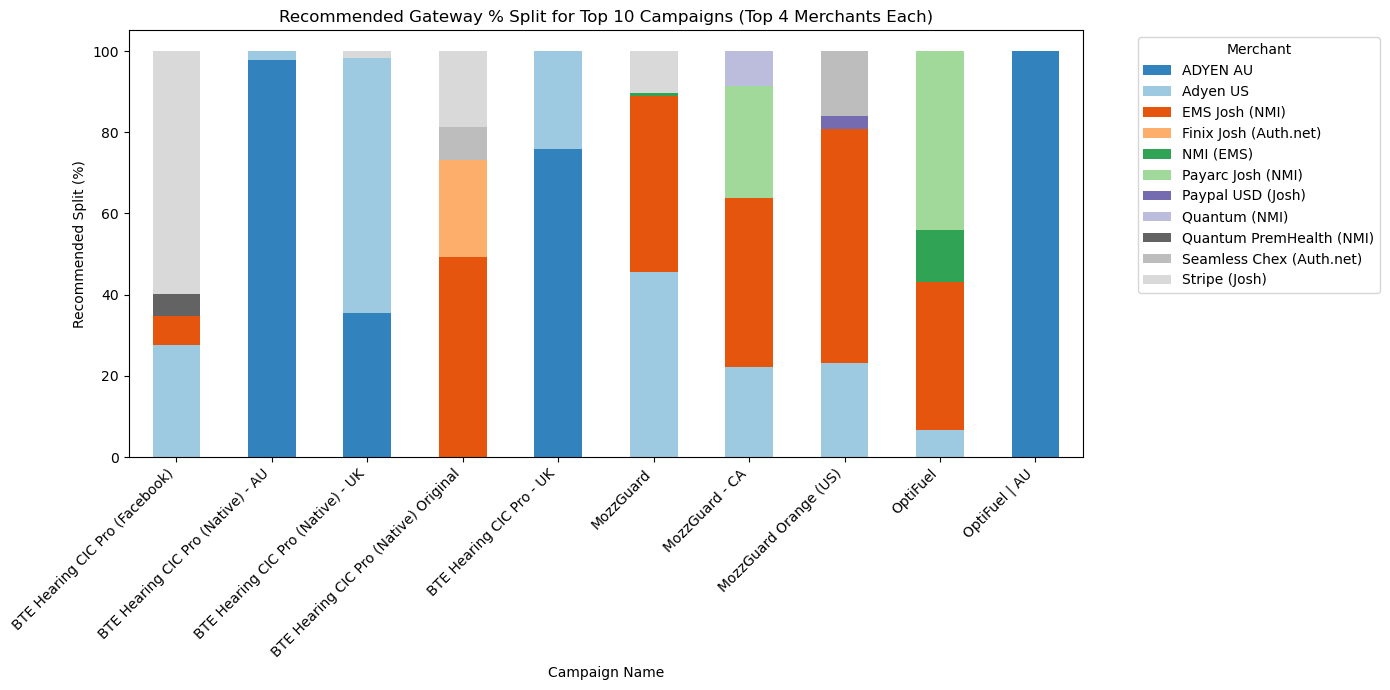

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pivot the data for plotting
plot_data = top_merchants.pivot_table(
    index='campaignName',
    columns='merchant',
    values='recommended_split_%',
    fill_value=0
)

# Plot
plot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='tab20c'
)

plt.title('Recommended Gateway % Split for Top 10 Campaigns (Top 4 Merchants Each)')
plt.ylabel('Recommended Split (%)')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Merchant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


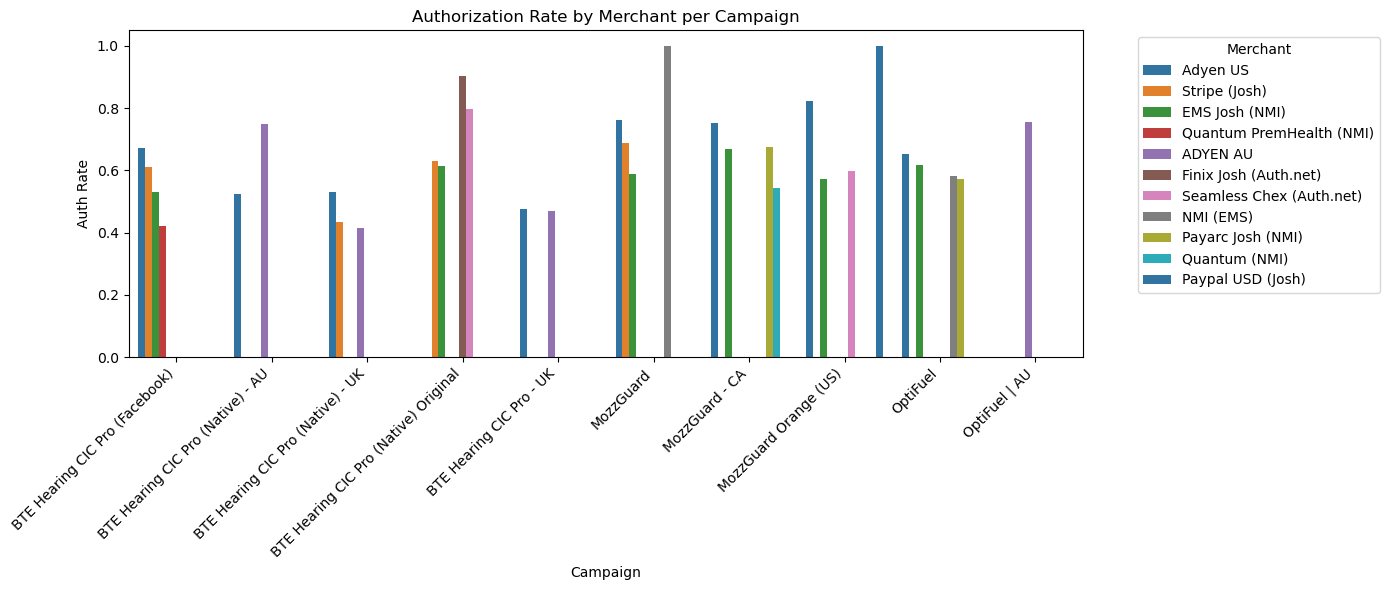

In [29]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=top_merchants,
    x='campaignName',
    y='auth_rate',
    hue='merchant',
    palette='tab10'
)
plt.title('Authorization Rate by Merchant per Campaign')
plt.ylabel('Auth Rate')
plt.xlabel('Campaign')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Merchant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


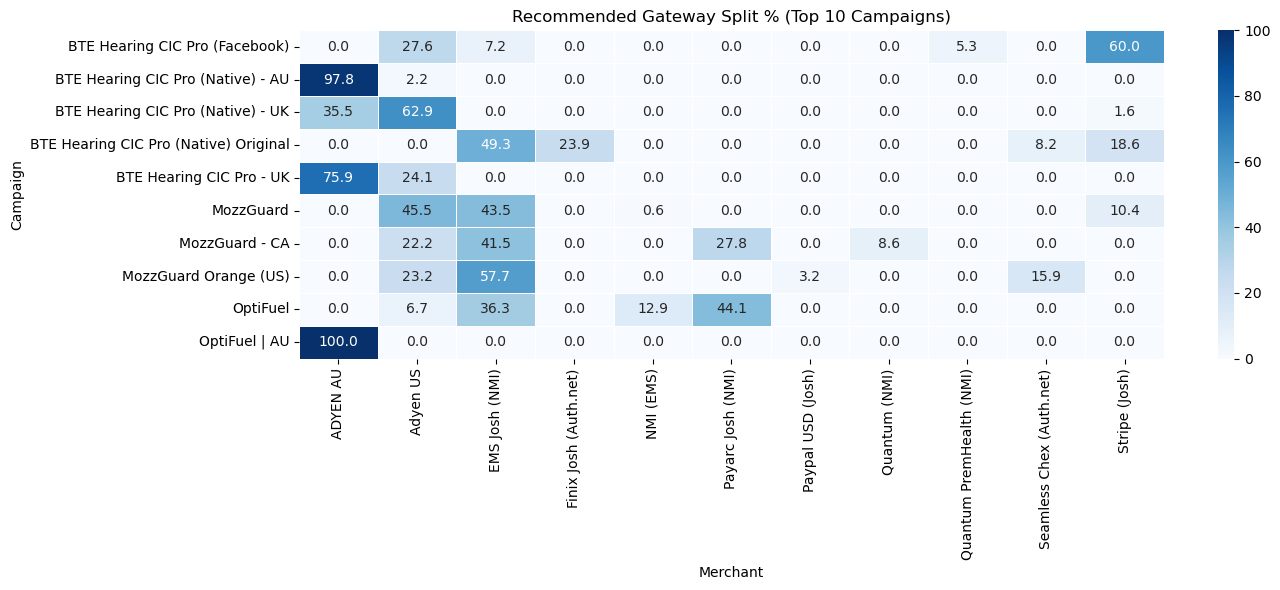

In [30]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    plot_data,  # from the stacked bar chart pivot
    annot=True,
    fmt=".1f",
    cmap='Blues',
    linewidths=0.5
)
plt.title('Recommended Gateway Split % (Top 10 Campaigns)')
plt.xlabel('Merchant')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()


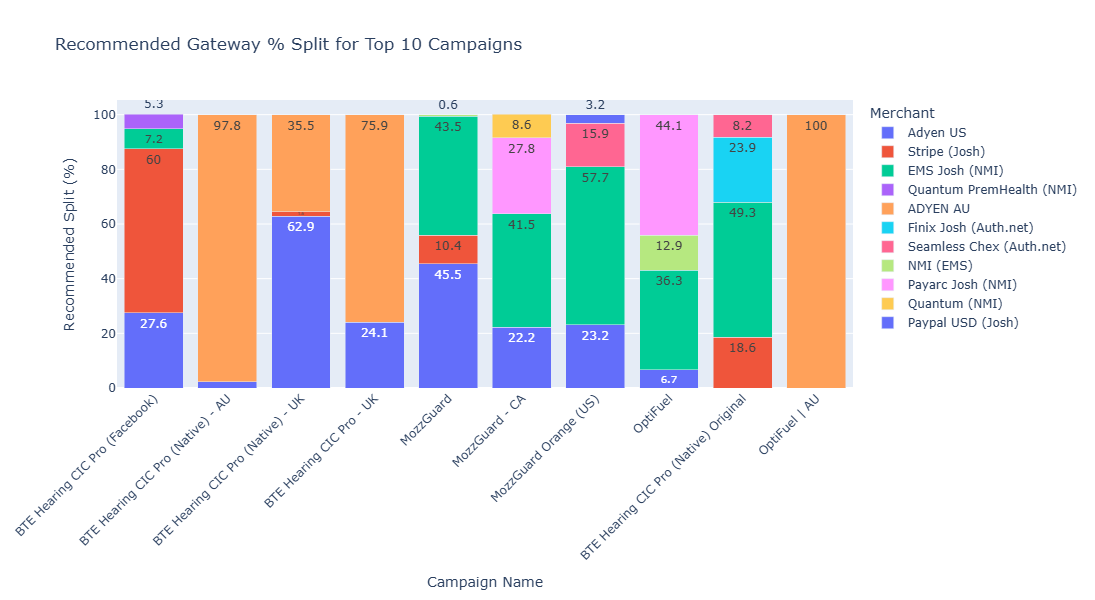

In [32]:
import plotly.express as px

fig = px.bar(
    top_merchants,
    x='campaignName',
    y='recommended_split_%',
    color='merchant',
    text='recommended_split_%',
    title='Recommended Gateway % Split for Top 10 Campaigns',
    labels={'recommended_split_%': 'Recommended Split (%)'},
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Campaign Name',
    yaxis_title='Recommended Split (%)',
    legend_title='Merchant',
    xaxis_tickangle=-45,
    height=600
)

fig.show()


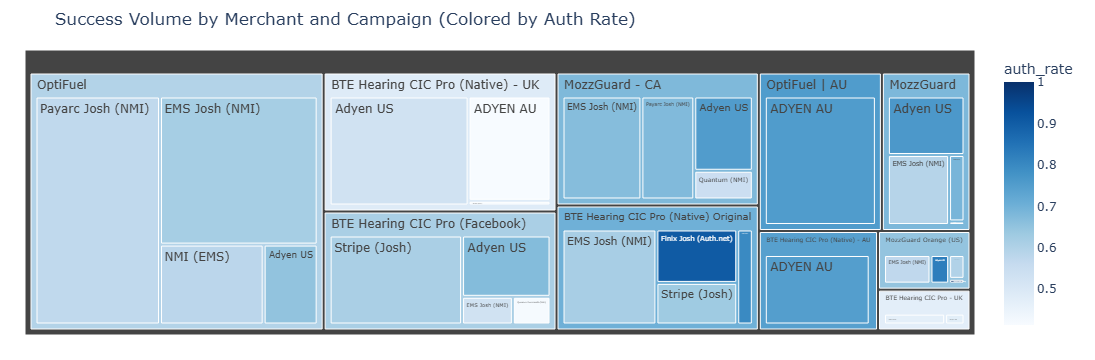

In [33]:
fig = px.treemap(
    top_merchants,
    path=['campaignName', 'merchant'],
    values='SUCCESS',
    color='auth_rate',
    color_continuous_scale='Blues',
    title='Success Volume by Merchant and Campaign (Colored by Auth Rate)',
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()
